In [ ]:
# !pip install git+https://github.com/openai/CLIP.git

In [1]:
import argparse
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.utils.data as data
from PIL import Image, ImageFile
from torchvision import transforms
from tqdm import tqdm
from template import imagenet_templates
import fast_stylenet 
from sampler import InfiniteSamplerWrapper
import clip
from template import imagenet_templates
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.transforms.functional import adjust_contrast
cudnn.benchmark = True
Image.MAX_IMAGE_PIXELS = None 
ImageFile.LOAD_TRUNCATED_IMAGES = True
import time
# from pypapi import events, papi_high as high


In [2]:
import argparse
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import cv2
import imageio
from torchvision import transforms
from torchvision.utils import save_image
import fast_stylenet
from torchvision.transforms.functional import adjust_contrast

from matplotlib import pyplot as plt

In [3]:
def test_transform():
    transform_list = [
        transforms.Resize(size=(512, 512)),
        transforms.ToTensor()
    ]
    return transforms.Compose(transform_list)

In [4]:
from omegaconf import OmegaConf

# parser = argparse.ArgumentParser()
# # Basic options
# parser.add_argument('--content_path', type=str, default='./test_set/boat.jpg',
#                     help='File path to the content image')
# parser.add_argument('--vgg', type=str, default='./pretrained/vgg_normalised.pth')
# parser.add_argument('--decoder', type=str, default='./pretrained/clip_decoder_anime.pth.tar')
# # Additional options
# parser.add_argument('--content_width', type=int, default=0,
#                     help='New (minimum) width for the content image, \
#                     keeping the original size if set to 0')
# parser.add_argument('--content_height', type=int, default=0,
#                     help='New (minimum) height for the content image, \
#                     keeping the original size if set to 0')
# parser.add_argument('--crop', action='store_true',
#                     help='do center crop to create squared image')
# # parser.add_argument('--save_ext', default='.mp4',
# #                     help='The extension name of the output video')
# parser.add_argument('--output', type=str, default='./outputs',
#                     help='Directory to save the output video')

# args = parser.parse_args()

args = {
    "content_path": '../GroundingDINO/demo/assets/tcl/in29.png',
    "vgg": './pretrained/vgg_normalised.pth',
    "decoder": './pretrained/decoder.pth',
    "output": "./outputs" 
}
args = OmegaConf.create(args)

device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

output_dir = Path(args.output)
output_dir.mkdir(exist_ok = True, parents = True)

decoder_path = Path(args.decoder)

assert (args.content_path)
if args.content_path:
    content_path = Path(args.content_path)

decoder = fast_stylenet.decoder
vgg = fast_stylenet.vgg

decoder.eval()
vgg.eval()

decoder.load_state_dict(torch.load(args.decoder))
vgg.load_state_dict(torch.load(args.vgg))
vgg = nn.Sequential(*list(vgg.children())[:31])

network = fast_stylenet.Net(vgg, decoder)
network.eval()
network.to(device)

Net(
  (enc_1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): ReflectionPad2d((1, 1, 1, 1))
    (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (enc_2): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
  )
  (enc_3): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
  )
  (enc_4): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(256, 256,

In [7]:
test_tf = test_transform()

loading image from.... ../GroundingDINO/demo/assets/tcl/in29.png


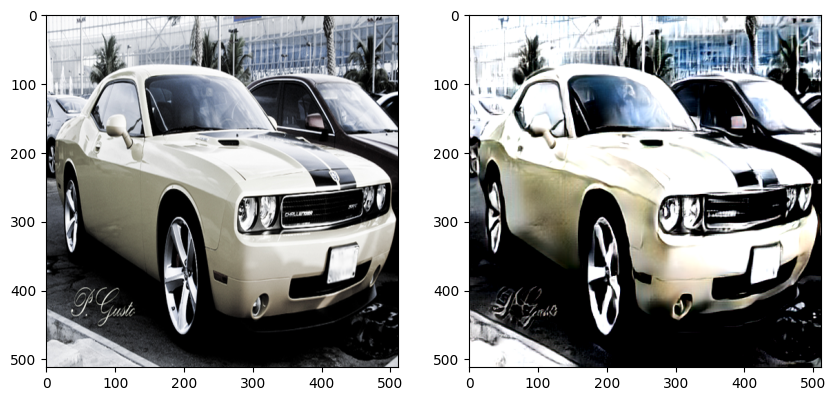

In [8]:
print(f'loading image from.... {args.content_path}')
rgb_im = Image.open(args.content_path)
test_img = test_tf(rgb_im)
test_img = test_img.to(device).unsqueeze(0)

with torch.no_grad():
    _,output = network(test_img)
    output = adjust_contrast(output,1.5)

output = output.cpu()
output = output.squeeze(0)
output = np.array(output)*255
#output = np.uint8(output)
output = np.transpose(output, (1,2,0)).astype(np.uint8)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5*2, 5))
axes[0].imshow(rgb_im.resize((512, 512), Image.Resampling.LANCZOS))
axes[1].imshow(output)
plt.show()

In [ ]:
#################### normal style transfer ########################

In [2]:
import os
import sys 
import matplotlib.pyplot as plt 
clipstyler_dir = os.path.join("/content", "clipstyler")

# !pip install ftfy regex tqdm 
# !pip install git+https://github.com/openai/CLIP.git
# !git clone https://github.com/paper11667/CLIPstyler/ $clipstyler_dir
# sys.path.append(clipstyler_dir)

from PIL import Image, ImageDraw
import numpy as np
import json
import sys
import torch
import torch.nn
import torch.optim as optim
from torchvision import transforms, models

import StyleNet
import utils
import clip
import torch.nn.functional as F
from template import imagenet_templates

from PIL import Image 
import PIL 
from torchvision import utils as vutils
import argparse
from torchvision.transforms.functional import adjust_contrast

In [3]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
VGG = models.vgg19(pretrained=True).features
VGG.to(device)

for parameter in VGG.parameters():
    parameter.requires_grad_(False)
    
def img_denormalize(image):
    mean=torch.tensor([0.485, 0.456, 0.406]).to(device)
    std=torch.tensor([0.229, 0.224, 0.225]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = image*std + mean
    return image


def img_normalize(image):
    mean=torch.tensor([0.485, 0.456, 0.406]).to(device)
    std=torch.tensor([0.229, 0.224, 0.225]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = (image-mean)/std
    return image


def clip_normalize(image,device):
    image = F.interpolate(image,size=224,mode='bicubic')
    mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]).to(device)
    std=torch.tensor([0.26862954, 0.26130258, 0.27577711]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = (image-mean)/std
    return image

    
def get_image_prior_losses(inputs_jit):
    diff1 = inputs_jit[:, :, :, :-1] - inputs_jit[:, :, :, 1:]
    diff2 = inputs_jit[:, :, :-1, :] - inputs_jit[:, :, 1:, :]
    diff3 = inputs_jit[:, :, 1:, :-1] - inputs_jit[:, :, :-1, 1:]
    diff4 = inputs_jit[:, :, :-1, :-1] - inputs_jit[:, :, 1:, 1:]

    loss_var_l2 = torch.norm(diff1) + torch.norm(diff2) + torch.norm(diff3) + torch.norm(diff4)
    
    return loss_var_l2

/disks/1/silky/miniconda3/envs/ldm/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/disks/1/silky/miniconda3/envs/ldm/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(700, 597)


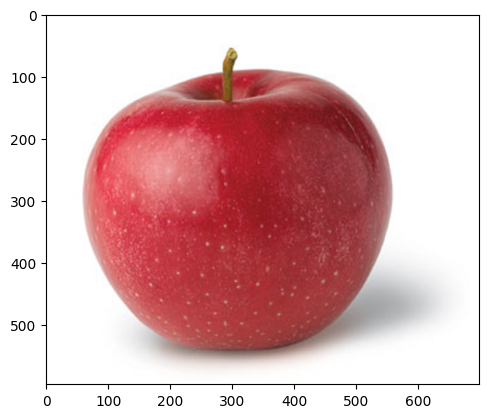

(128, 128)


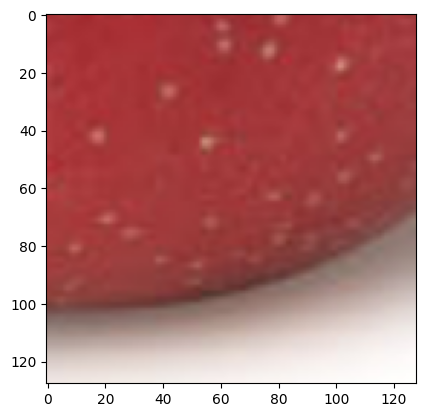

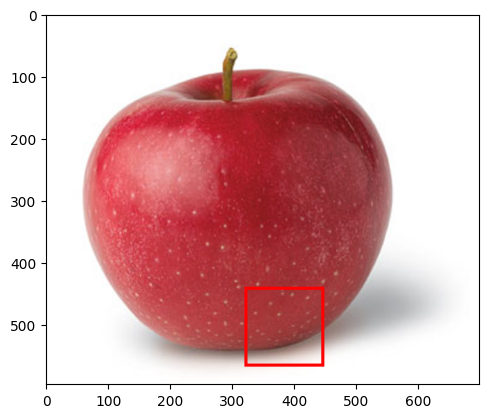

In [11]:
cropper = transforms.Compose([
    transforms.RandomCrop(128)
])

trans = transforms.Compose([transforms.ToTensor()])
pil_img = Image.open("../GroundingDINO/demo/assets/tcl/in36.png")
print(pil_img.size)
plt.imshow(pil_img)
plt.show()

pil_t = trans(pil_img)
top, left, h, w = transforms.RandomCrop(128).get_params(pil_img, (128, 128))

cropped = transforms.functional.crop(pil_img, top, left, h, w)
print(cropped.size)
plt.imshow(cropped)
plt.show()

img = ImageDraw.Draw(pil_img)
img.rectangle(xy=(left, top, left+w, top+h), outline=(255,0,0), width=5)
plt.imshow(pil_img)
plt.show()


(tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([100, 100, 100,  ..., 499, 499, 499]), tensor([200, 201, 202,  ..., 297, 298, 299]))
200 299 100 499


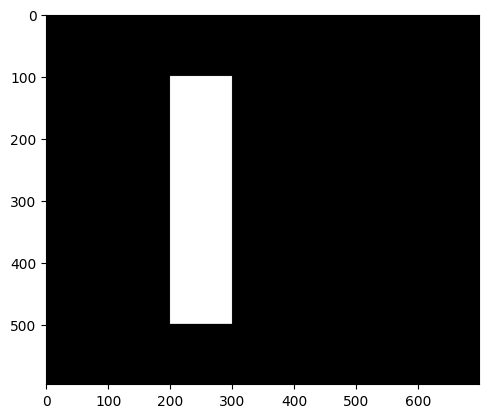

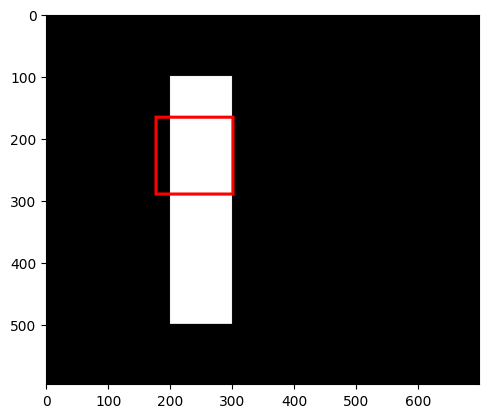

In [12]:
seg_mask = torch.zeros((1, 597, 700))
seg_mask[:, 100:500, 200:300] = 1.

ones = torch.where(seg_mask == 1.)
print(ones)
left, right, top, bottom = torch.min(ones[2]).item(), torch.max(ones[2]).item(), torch.min(ones[1]).item(), torch.max(ones[1]).item()
print(left, right, top, bottom)

segnp = seg_mask[0].numpy()
plt.imshow((segnp*255.).astype(np.uint8), cmap='gray')
plt.show()

patch_size = 128

left_patch, top_patch = None, None
right_limit = right-patch_size+1
if right_limit < left:
    left_patch = np.random.randint(right_limit, left)

bottom_limit = bottom-patch_size+1
if bottom_limit < top:
    top_patch = np.random.randint(bottom_limit, top)
    
if left_patch is None:
    left_patch = np.random.randint(left, right_limit)
    
if top_patch is None:
    top_patch = np.random.randint(top, bottom_limit)
    

seg_pil = Image.fromarray((segnp*255.).astype(np.uint8)).convert("RGB")
# plt.imshow(seg_pil)
# plt.show()
seg = ImageDraw.Draw(seg_pil)
seg.rectangle(xy=(left_patch, top_patch, left_patch+patch_size, top_patch+patch_size), outline=(255,0,0), width=5)

plt.imshow(seg_pil, cmap='gray')
plt.show()


In [ ]:
# picking qual results to show 
target_path = '../text-style-transfer/outputs_10x10'

images = os.listdir(target_path)
text2live = list(filter(lambda fn: fn.startswith('text2live_vanilla'), images))
assert len(text2live) == 100, "text2live image numbers don't match!"

for vanilla in text2live:
    print('*'*10, vanilla)
    vanilla_img = Image.open(os.path.join(target_path, vanilla))
    gatha_1e8 = Image.open(os.path.join(target_path, vanilla.replace('text2live_vanilla', 'text2live_with_gatha')))
    gatha_2e8 = Image.open(os.path.join(target_path, vanilla.replace('text2live_vanilla', 'text2live_with_gatha_beta=2e-8')))
    gatha_1e7 = Image.open(os.path.join(target_path, vanilla.replace('text2live_vanilla', 'text2live_with_gatha_beta=1e-7')))
    
    fig,axes = plt.subplots(nrows=1, ncols=4, figsize=(5*4,5))
    axes[0].imshow(vanilla_img)
    axes[0].set_title("Text2live vanilla")
    axes[1].imshow(gatha_1e8)
    axes[1].set_title("w/ Gatha 1e-8")
    axes[2].imshow(gatha_2e8)
    axes[2].set_title("w/ Gatha 2e-8")
    axes[3].imshow(gatha_1e7)
    axes[3].set_title("w/ Gatha 1e-7")
    plt.show()
    
    

In [15]:
# specifically for Gatha/relational loss.
clip_model, preprocess = clip.load('ViT-B/32', device, jit=False)

styles = ['Fun', 'Playful', 'Vibrant', 'Vintage', 'Gold', 'Abstract', 'Collage', 'Polaroid', 'Colorful', 'Feminine', 'Bold', 'Rustic', 'Cute', 'Logo', 'Round', 'Happy', 'Photo', 'Black And White', 'Beautiful', 'New', 'Illustrated', 'Calligraphy', 'Aesthetic', 'Light', 'Clean', 'Texture', 'Corporate', 'Gradient', 'Classy', 'Professional', 'Minimal', 'Circle', 'Elegant', 'Blank', 'Minimalist', 'Modern', 'Festive', 'Floral', 'Animated', 'Pattern', 'Luxury', 'Classic', 'Funny', 'Frame', 'Border', 'Dark', 'Retro', 'Cartoon', 'Creative', 'Glitter', 'Organic', 'Lines', 'Line', 'Geometric', 'Sparkle', 'Watercolor', 'Simple', 'Papercraft', 'Script', 'Cool', 'Illustration', 'Dots', 'Grid', 'Handwriting', 'Blob', 'Table', 'Neon', 'Pastel', 'Fancy', 'Art Deco', 'Artistic', 'Cursive', 'Rainbow', 'Glow', 'Maximalist', 'Infographic', 'Funky', 'Rectangle', 'Sketch', 'Plain', 'Neat', 'Dotted', 'Curved Text', 'Arrow', 'Marble', 'Charcoal', 'Natural Scrapbook', 'Fitness', 'Transparent', 'Hipster', 'Tech', 'Grunge'] 
theme = ['School', 'Education', 'Classroom', 'Fun', 'Event', 'Corporate', 'Greeting', 'Photo', 'Illustration', 'Pink', 'Floral', 'Business', 'Beauty', 'Product', 'Invitation', 'Elementary', 'Birthday', 'Monthly', 'Marketing', 'Vintage', 'Post', 'Tropical', 'Sale', 'Typography', 'Motivational', 'Student', 'Welcome', 'Quote', 'Note', 'Love', 'New', "Valentine's Day", 'Fashion', 'Funny', 'Congratulations', 'Baby', 'Festival', 'Personal', 'Food', 'Art', 'Kids', 'Label', 'Thank You', 'Nature', 'Line', 'Icon', 'Music', 'Black And White', 'Restaurant', 'Drink', 'Daily', 'Collage', 'Travel', 'Wedding', 'Engagement', 'Summer', 'Announcement', 'Ad', 'Christmas', 'Holiday', 'Cake', 'Company', 'Family', 'New Year', 'Cafe', 'Background', 'Dessert', 'Party', 'Pet', 'Winter', 'Gift', 'Santa', 'Formal', 'Advertising', 'Official', 'Header', 'Law Firm', 'Retail', 'Clothing', 'Kindergarten', 'Preschool', 'Recipe', 'Inspirational', 'Coloring', 'English', 'Quiz', 'Math', 'Email', 'Fancy', 'Promotional', 'Concert', 'Designer', 'Bingo', 'Chinese New Year', 'DJ', 'This Or That', 'YouTube', 'Sales', 'Club', 'Car'] 
categories = ['Presentation', 'Whiteboard', 'Prototype', 'Mind Map', 'Website', 'Graph', 'Planner', 'Letterhead', 'Calendar', 'Resume', 'Invoice', 'Proposal', 'Report', 'Instagram Post (Square)', 'Instagram Post (Square)', 'Instagram Story', 'Instagram Reel', 'Facebook Post', 'Facebook Cover', 'Facebook Ad', 'Your Story', 'TikTok Video', 'LinkedIn Video Ad', 'Animated Social Media', 'Twitter Post', 'Video (16:9)', 'Video (16:9)', 'Facebook Video', 'Video Message', 'Mobile Video', 'Video Collage', 'YouTube Video', 'Feed Ad Video (Portrait)', 'Business Card', 'Business Card', 'Flyer', 'Logo', 'Poster (Portrait)', 'Brochure', 'Menu', 'Newsletter', 'Infographic', 'T-Shirt', 'T-Shirt', 'Canvas Print', 'Sticker', 'Mug', 'Photo Book', 'Label', 'Hoodie', 'Banner', 'Yard Sign', 'Certificate', 'Invitation', 'Invitation', 'Card', 'Postcard', 'Education Presentation', 'Education Presentation', 'Educational Video', 'Education Infographic', 'Classroom Poster', 'Worksheet', 'Flashcard', 'Storyboard', 'Comic Strip', 'Group Work', 'Classroom Newsletter', 'School Newsletter']

styles = styles + theme + categories

clip_sty_prompts_single = ["in the corresponding generated photo of a portrait of a man, is the style looking like {}?".format(sty) for sty in styles]  # "is the style {}?"
style_caption_prompts = [clip_model.encode_text(clip.tokenize([sty]).detach().to(device)) for sty in clip_sty_prompts_single]
style_caption_prompts = torch.cat(style_caption_prompts, dim=0)
style_caption_prompts /= style_caption_prompts.norm(dim=-1, keepdim=True)

# style_tensor1 = torch.zeros(261, 512).to(device)
# for i in range(len(styles)):
# #     style_caption_prompts[i] /= style_caption_prompts[i].norm(dim=-1, keepdim=True)
#     style_tensor1[i] = style_caption_prompts[i]/style_caption_prompts[i].norm(dim=-1, keepdim=True)

# style_tensor1 = style_tensor1.detach()
style_tensor = style_caption_prompts.detach()


In [ ]:
print(style_tensor.shape, torch.min(style_tensor), torch.max(style_tensor))

In [ ]:
# Mask-CLIPstyler + Gatha(relational) loss 
from argparse import Namespace
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
import sys
import timeit

source = "a Photo"

text = f"colorful stained glass."   # "Sketch with black pencil" 
crop_size = 128
image_dir = f"../GroundingDINO/demo/assets/tcl/in45.png"  
save_path = f"../text-style-transfer/outputs/mclipstyler+gatha_church_cubism.png"
seg_path = f"../GroundingDINO/demo/outputs/in45_seg_teapot.png" # "../text-style-transfer/outputs/church_water_body_01.png"


training_iterations = 200 # @param {type: "integer"}

training_args = {
    "lambda_tv": 0,   # 2e-3, 0 
    "lambda_patch": 9000,  # 9000
    "lambda_dir": 500,  # 500
    "lambda_c": 100, # 150
    "lambda_identity": 0, # 7000
    "lambda_gatha": 0.00005,
    "crop_size": 128,
    "num_crops": 64,
    "img_height": 512,
    "img_width": 512,
    "max_step": training_iterations,
    "lr": 5e-4,
    "thresh": 0.7,
    "content_path": image_dir,
    "text": text
}


# training_args = {
#     "lambda_tv": 2e-3,  # 2e-3,0
#     "lambda_patch": 9000,
#     "lambda_dir": 500,
#     "lambda_c": 150,
#     "lambda_identity": 7000,
#     "lambda_gatha": 0.00005,
#     "crop_size": 128,
#     "num_crops":64,
#     "img_height":512,
#     "img_width":512,
#     "max_step":training_iterations,
#     "lr":5e-4,
#     "thresh":0.7,
#     "content_path":image_dir,
#     "text":text
# }

args = Namespace(**training_args)

def compose_text_with_templates(text: str, templates=imagenet_templates) -> list:
    return [template.format(text) for template in templates]

def get_bbox_from_seg(seg_mask):
    ones = torch.where(seg_mask == 1.)
    left, right, top, bottom = torch.min(ones[3]).item(), torch.max(ones[3]).item(), torch.min(ones[2]).item(), torch.max(ones[2]).item()
    return left, top, right, bottom

def get_crop_coordinates(pil_t, seg_mask, patch_size=args.crop_size):
    left, top, right, bottom = get_bbox_from_seg(seg_mask)
#     print(f'left: {left}, top: {top}, right: {right}, bottom: {bottom}')

    left_patch, top_patch = None, None
    right_limit = right-patch_size+1
    if right_limit < left:
        left_patch = np.random.randint(right_limit, left)

    bottom_limit = bottom-patch_size+1
    if bottom_limit < top:
        top_patch = np.random.randint(bottom_limit, top)

    if left_patch is None:
        left_patch = np.random.randint(left, right_limit)

    if top_patch is None:
        top_patch = np.random.randint(top, bottom_limit)
        
    return top_patch, left_patch, patch_size, patch_size

content_path = args.content_path
content_image = utils.load_image2(content_path, img_height=args.img_height,img_width =args.img_width)
content_image = content_image.to(device)

segmask_image = utils.load_seg_mask(seg_path, img_height=args.img_height, img_width=args.img_width)
segmask_image = segmask_image.to(device)

content_features = utils.get_features(img_normalize(content_image), VGG)

# '''
# to preserve the content of the image except the region being styled: content_image*(1.-segmask_image) 
# '''
masked_content_features = utils.get_features(img_normalize(content_image*(1.-segmask_image)), VGG)


target = content_image.clone().requires_grad_(True).to(device)


style_net = StyleNet.UNet(input_channel=4)  # input_channel=4
style_net.to(device)
style_net.load_state_dict(torch.load("./init_sty_channel4.pth", map_location='cpu'))  # nice trick to maintain consistency across experiments!

style_weights = {'conv1_1': 0.1,
                 'conv2_1': 0.2,
                 'conv3_1': 0.4,
                 'conv4_1': 0.8,
                 'conv5_1': 1.6}

content_weight = args.lambda_c

show_every = 100
optimizer = optim.Adam(style_net.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
steps = args.max_step

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []

output_image = content_image

m_cont = torch.mean(content_image,dim=(2,3),keepdim=False).squeeze(0)
m_cont = [m_cont[0].item(),m_cont[1].item(),m_cont[2].item()]

cropper = transforms.Compose([
    transforms.RandomCrop(args.crop_size)
])
augment = transforms.Compose([
    transforms.RandomPerspective(fill=0, p=1,distortion_scale=0.5),
    transforms.Resize(224)
])

# clip_model, preprocess = clip.load('ViT-B/32', device, jit=False)

prompt = args.text

source = "a Photo"

with torch.no_grad():
    template_text = compose_text_with_templates(prompt, imagenet_templates)
    tokens = clip.tokenize(template_text).to(device)
    text_features = clip_model.encode_text(tokens).detach()
    text_features = text_features.mean(axis=0, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    
    template_source = compose_text_with_templates(source, imagenet_templates)
    tokens_source = clip.tokenize(template_source).to(device)
    text_source = clip_model.encode_text(tokens_source).detach()
    text_source = text_source.mean(axis=0, keepdim=True)
    text_source /= text_source.norm(dim=-1, keepdim=True)
    source_features = clip_model.encode_image(clip_normalize(content_image,device))
    source_features /= (source_features.clone().norm(dim=-1, keepdim=True))
    style_embed = ( 1e3 * text_features.float() @ style_tensor.T).detach().expand(64, len(styles))
    
    masked_source_features = clip_model.encode_image(clip_normalize(content_image*segmask_image,device))
    masked_source_features /= (masked_source_features.clone().norm(dim=-1, keepdim=True))


T = 1
# style_embed = F.softmax(style_embed/T, dim=-1)

criterion = nn.KLDivLoss()

num_crops = args.num_crops
bbox_left, bbox_top, bbox_right, bbox_bottom = get_bbox_from_seg(segmask_image)

# torch.save(style_net.state_dict(), './init_sty_channel4.pth')
# sys.exit("Model init saved.")
start = timeit.time()
import sys; sys.exit()
for epoch in range(0, steps+1):
    scheduler.step()
    
    image_with_mask = torch.cat([content_image, segmask_image], dim=1)   # 1x4x512x512
    target = style_net(image_with_mask, use_sigmoid=True).to(device)
#     target = style_net(content_image, use_sigmoid=True).to(device)
    target.requires_grad_(True)
    
#     identity loss - L1
    loss_identity = torch.nn.L1Loss()(target*(1.-segmask_image), content_image*(1.-segmask_image))
    
    target_features = utils.get_features(img_normalize(target), VGG)
    masked_target_features = utils.get_features(img_normalize(target*(1.-segmask_image)), VGG)
    
    content_loss = 0

    content_loss += torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    content_loss += torch.mean((target_features['conv5_2'] - content_features['conv5_2']) ** 2)

    loss_patch=0 
    img_proc =[]
    for n in range(num_crops):
#         target_crop = cropper(target)
#         target_crop = augment(target_crop)
#         img_proc.append(target_crop)

        top, left, h, w = get_crop_coordinates(target, segmask_image)
        target_crop = transforms.functional.crop(target, top, left, h, w)
        seg_crop = transforms.functional.crop(segmask_image, top, left, h, w)
        target_crop = augment(target_crop*seg_crop)
        img_proc.append(target_crop)

    img_proc = torch.cat(img_proc,dim=0)
    img_aug = img_proc

    image_features = clip_model.encode_image(clip_normalize(img_aug,device))
    image_features /= (image_features.clone().norm(dim=-1, keepdim=True))
    
    img_direction = (image_features-source_features)
    img_direction /= img_direction.clone().norm(dim=-1, keepdim=True)
    
    text_direction = (text_features-text_source).repeat(image_features.size(0),1)
    text_direction /= text_direction.norm(dim=-1, keepdim=True)
    loss_temp = (1. - torch.cosine_similarity(img_direction, text_direction, dim=1))
    loss_temp[loss_temp<args.thresh] =0
    loss_patch+=loss_temp.mean()
    
#     glob_features = clip_model.encode_image(clip_normalize(target,device))
#     glob_features /= (glob_features.clone().norm(dim=-1, keepdim=True))
    
#     glob_direction = (glob_features-source_features)
#     glob_direction /= glob_direction.clone().norm(dim=-1, keepdim=True)
    
    masked_glob_features = clip_model.encode_image(clip_normalize(target*segmask_image, device))
    masked_glob_features /= (masked_glob_features.clone().norm(dim=-1, keepdim=True))
    
    glob_direction = (masked_glob_features - masked_source_features)
    glob_direction /= glob_direction.clone().norm(dim=-1, keepdim=True)
    
    loss_glob = (1- torch.cosine_similarity(glob_direction, text_direction, dim=1)).mean()
    
    reg_tv = args.lambda_tv*get_image_prior_losses(target)  # (target*segmask_image)

    sty_lab = (1e3 * image_features.float() @ style_tensor.T)
    
#     sty_lab = (sty_lab - sty_lab.min())/(sty_lab.max() - sty_lab.min())
#     sty_lab2 = (1e3 * glob_features.float() @ style_tensor.T)
#     style_embed = (style_embed - style_embed.min()) / (style_embed.max() - style_embed.min())


    
#     kl = T * T * criterion(sty_lab, style_embed)
    kl = args.lambda_gatha * F.mse_loss(sty_lab, style_embed) 

#     + 0.0001 * F.mse_loss(sty_lab2, style_embed[0].unsqueeze(0))
    total_loss = args.lambda_patch*loss_patch + content_weight * content_loss+ reg_tv+ args.lambda_dir*loss_glob +\
                    args.lambda_identity*loss_identity
    total_loss += kl
    total_loss_epoch.append(total_loss)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print("After %d iters:" % epoch)
        print('Total loss: ', total_loss.item())
#         print('Content loss: ', content_loss.item())
#         print('patch loss: ', loss_patch.item())
#         print('dir loss: ', loss_glob.item())
#         print('TV loss: ', reg_tv.item())
#         print("KL Loss:", kl.item())
#         print("Sty Sim: ", sty_lab.mean())
        
        print('Content loss: ', content_loss.item() * args.lambda_c)
        print('patch loss: ', loss_patch.item() * args.lambda_patch)
        print('dir loss: ', loss_glob.item() * args.lambda_dir)
        print('TV loss: ', reg_tv.item())
        print('Identity loss:', loss_identity.item()*args.lambda_identity)
        print('Relational loss(Gatha):', kl.item())
    
    if epoch % 50 ==0:

        output_image = target.clone()
        output_image = torch.clamp(output_image,0,1)
        output_image = adjust_contrast(output_image,1.5)
        output_converted = utils.im_convert2(output_image)
        plt.imshow(output_converted)
        plt.show()

# Image.fromarray((output_converted*255.).astype(np.uint8)).save(save_path)
# with stitching..
src = np.array(Image.open(content_path).resize((args.img_width, args.img_height), Image.BICUBIC))
sty1 = (output_converted*255.).astype(np.uint8)
seg1 = np.array(Image.open(seg_path).resize((args.img_width, args.img_height), Image.NEAREST).convert("RGB"))/255.

styled = (sty1 * seg1 + (1.-seg1) * src).astype(np.uint8)
# Image.fromarray(styled).save(save_path) 

print(f"following image saved to {save_path}.")
plt.imshow(styled)
plt.show()

print(f"original image.")
plt.imshow(Image.open(image_dir).resize((512,512), resample=Image.BICUBIC))
plt.show()
        


In [3]:
####################################### COMPOSITIONAL CLIPSTYLER ###########################################

In [4]:
# imports and pre-load the LLaVA and SAM models here.
from IPython.display import display
from argparse import Namespace

def compose_text_with_templates(text: str, templates=imagenet_templates) -> list:
    return [template.format(text) for template in templates]

def get_bbox_from_seg(seg_mask):
    ones = torch.where(seg_mask == 1.)
    left, right, top, bottom = max(0, torch.min(ones[3]).item()), torch.max(ones[3]).item(), max(0, torch.min(ones[2]).item()), torch.max(ones[2]).item()
    return left, top, right, bottom

def get_crop_coordinates(pil_t, seg_mask, patch_size):
    left, top, right, bottom = get_bbox_from_seg(seg_mask)

    left_patch, top_patch = None, None
    right_limit = max(right-patch_size+1, 0)
    if right_limit < left:
        left_patch = np.random.randint(right_limit, left)

    bottom_limit = max(bottom-patch_size+1, 0)
    if bottom_limit < top:
        top_patch = np.random.randint(bottom_limit, top)

    if left_patch is None:
        left_patch = np.random.randint(left, right_limit+1)  # adding 1 to bypass [low, high) 

    if top_patch is None:
        top_patch = np.random.randint(top, bottom_limit+1)
        
    return top_patch, left_patch, patch_size, patch_size


import sys
sys.path.append('../')
from text_to_seg import pre_load_models, get_segmentation_from_user_prompt

tokenizer, model, image_processor, predictor = pre_load_models()


You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
from torchmetrics.multimodal.clip_score import CLIPScore
metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16").to(device)

def patchCLIPscore(images, seg_mask, text, num_crops=64, crop_size=224):
    scores = []
    
    left, top, right, bottom = get_bbox_from_seg(seg_mask)
    for idx,img in enumerate(images):
        print('calculating CLIP score..', torch.min(img), torch.max(img))
        cropped = transforms.functional.crop(img, top, left, bottom-top, right-left)
        score = metric(cropped, text)
        scores.append(score.item())
    
    
#     get crops w/in the bbox and avg the clip scores over num_crops
#     for i in range(num_crops):
#         top,left,_,_ = get_crop_coordinates(None, seg_mask, crop_size)
        
#         for idx,img in enumerate(images):
#             cropped = transforms.functional.crop(img, top, left, crop_size, crop_size)
#             score = metric(cropped, text)

#             if i == 0:
#                 scores.append(score.item())
#             else:
#                 scores[idx] = scores[idx]+score.item()
                 
#     scores = [score/num_crops for score in scores]
    return scores
            

Llava output => The bounding box coordinates for the chair on the left of the sofa are: [0.000,0.556,0.177,0.919]. The corresponding style to be applied is "Starry Night by Van Gogh".
running CLIPstyler with style => starry night by van gogh
After 0 iters:
Total loss:  14534.9951171875
Content loss:  4478.840160369873
patch loss:  9541.015625
dir loss:  512.20703125
TV loss:  0.1556919813156128


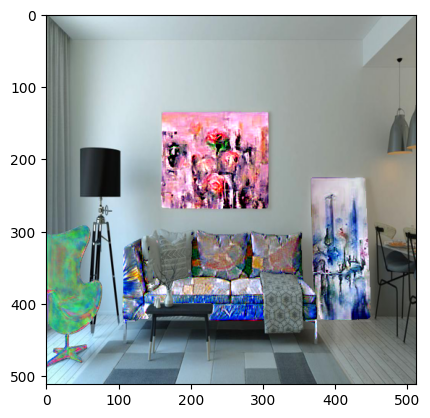

After 50 iters:
Total loss:  11402.251953125
Content loss:  3409.347724914551
patch loss:  7563.4765625
dir loss:  428.7109375
TV loss:  0.15422232449054718


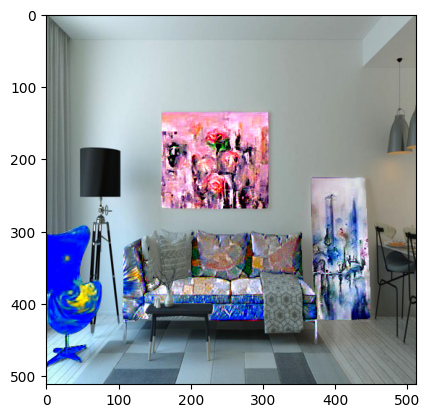

After 100 iters:
Total loss:  8873.71484375
Content loss:  2916.5428161621094
patch loss:  5551.7578125
dir loss:  405.029296875
TV loss:  0.17224149405956268


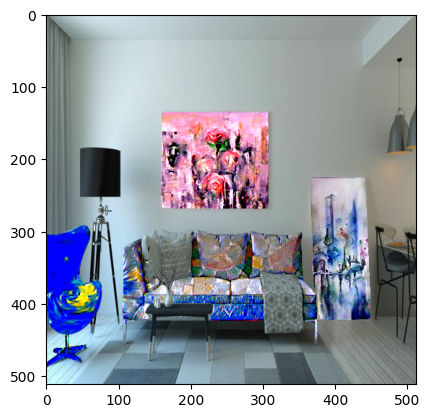

After 150 iters:
Total loss:  6342.03759765625
Content loss:  2684.6056938171387
patch loss:  3261.71875
dir loss:  395.263671875
TV loss:  0.1821965128183365


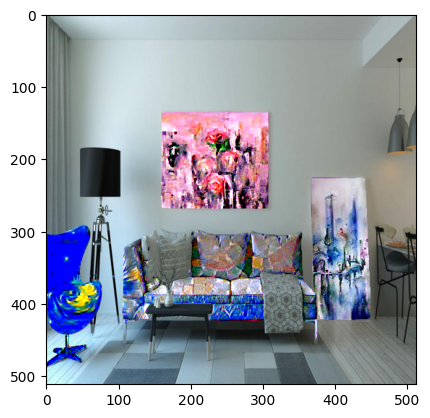

After 200 iters:
Total loss:  7453.9755859375
Content loss:  2551.285171508789
patch loss:  4511.71875
dir loss:  390.380859375
TV loss:  0.19057659804821014


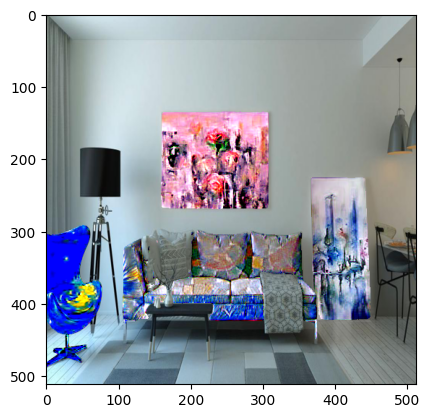

In [18]:
image_dir = "compositional_outputs/paper_results/interior1_mosaic_roses_watercolor.png" # f"../tcl/extras/interior2.jpeg" # f"compositional_outputs/paper_results/boat_cubism.png"
text = f"apply Starry Night by Van Gogh style to the chair on the left of sofa in the image"

seg_mask, style_text = get_segmentation_from_user_prompt(image_dir, text, tokenizer, model, image_processor, predictor)
# style_text = "fauvism"
print("running CLIPstyler with style =>", style_text)

clip_model, preprocess = clip.load('ViT-B/32', device, jit=False)


training_iterations = 200  # default = 200 
training_args = {
    "lambda_tv": 2e-3,   # default = 2e-3
    "lambda_patch": 10000,  # default = 9000, 10000
    "lambda_dir": 500,  # default = 500
    "lambda_c": 150, # default = 150
    "lambda_identity": 7000,  # not used
    "crop_size": 100,  # default = 128, 100
    "num_crops": 64,  # default = 64 
    "img_height": 512,
    "img_width": 512,
    "max_step": training_iterations,
    "lr": 5e-4,
    "thresh": 0.7,
    "content_path": image_dir,
    "text": style_text
}

args = Namespace(**training_args)


content_path = args.content_path
content_image = utils.load_image(content_path, args.img_height) # img_height=args.img_height, img_width =args.img_width
content_image = content_image.to(device)

seg_mask = Image.fromarray((seg_mask*255.).astype(np.uint8))
segmask_image = utils.load_seg_mask2(seg_mask, img_height=args.img_height, img_width=args.img_width)
segmask_image = segmask_image.to(device)

bbox_left, bbox_top, bbox_right, bbox_bottom = get_bbox_from_seg(segmask_image)

content_features = utils.get_features(img_normalize(content_image), VGG)
masked_content_features = utils.get_features(img_normalize(content_image*(segmask_image)), VGG)

cropped_content_image = transforms.functional.resized_crop(content_image, bbox_top, bbox_left, bbox_bottom-bbox_top, bbox_right-bbox_left, (args.img_height, args.img_width))
cropped_content_features = utils.get_features(img_normalize(cropped_content_image), VGG)

# target = content_image.clone().requires_grad_(True).to(device)

style_net = StyleNet.UNet(input_channel=3)
style_net.to(device)
style_net.load_state_dict(torch.load("./compositional.pth", map_location='cpu'))

style_weights = {'conv1_1': 0.1,
                 'conv2_1': 0.2,
                 'conv3_1': 0.4,
                 'conv4_1': 0.8,
                 'conv5_1': 1.6}

content_weight = args.lambda_c

show_every = 100
optimizer = optim.Adam(style_net.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
steps = args.max_step

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []

output_image = content_image

m_cont = torch.mean(content_image,dim=(2,3), keepdim=False).squeeze(0)
m_cont = [m_cont[0].item(), m_cont[1].item(), m_cont[2].item()]

cropper = transforms.Compose([
    transforms.RandomCrop(args.crop_size)
])
augment = transforms.Compose([
    transforms.RandomPerspective(fill=0, p=1, distortion_scale=0.5),
    transforms.Resize(224)
])

prompt = args.text
source = "a Photo"

with torch.no_grad():
    template_text = compose_text_with_templates(prompt, imagenet_templates)
    tokens = clip.tokenize(template_text).to(device)
    text_features = clip_model.encode_text(tokens).detach()
    text_features = text_features.mean(axis=0, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    template_source = compose_text_with_templates(source, imagenet_templates)
    tokens_source = clip.tokenize(template_source).to(device)
    text_source = clip_model.encode_text(tokens_source).detach()
    text_source = text_source.mean(axis=0, keepdim=True)
    text_source /= text_source.norm(dim=-1, keepdim=True)

#     print('content image size:', content_image.size())  # 1, 3, 512, 512
#     print('seg mask size:', segmask_image.size())       # 1, 1, 512, 512 
    source_features = clip_model.encode_image(clip_normalize(content_image, device))
    source_features /= (source_features.clone().norm(dim=-1, keepdim=True))

    masked_source_features = clip_model.encode_image(clip_normalize(content_image*segmask_image,device))
    masked_source_features /= (masked_source_features.clone().norm(dim=-1, keepdim=True))

    cropped_source_features = clip_model.encode_image(clip_normalize(cropped_content_image,device))
    cropped_source_features /= (cropped_source_features.clone().norm(dim=-1, keepdim=True))

num_crops = args.num_crops

for epoch in range(0, steps+1):
    scheduler.step()

#     image_with_mask = torch.cat([content_image, segmask_image], dim=1)   # 1x4x512x512
    target = style_net(content_image, use_sigmoid=True).to(device)

#     target = style_net(content_image, use_sigmoid=True).to(device)
#     print('target size:', target.size())  # 1, 3, 512, 512
    target.requires_grad_(True) 

    target_cropped = transforms.functional.resized_crop(target, bbox_top, bbox_left, bbox_bottom-bbox_top, bbox_right-bbox_left, (args.img_height, args.img_width))

#     L1 loss- identity preservation on non-styled region
#     loss_identity = torch.nn.L1Loss()(target*(1.-segmask_image), content_image*(1.-segmask_image))
    target_features = utils.get_features(img_normalize(target), VGG)
    masked_target_features = utils.get_features(img_normalize(target*(segmask_image)), VGG)
    cropped_target_features = utils.get_features(img_normalize(target_cropped), VGG)

    content_loss = 0
    content_loss += torch.mean((cropped_target_features['conv4_2'] - cropped_content_features['conv4_2']) ** 2)
    content_loss += torch.mean((cropped_target_features['conv5_2'] - cropped_content_features['conv5_2']) ** 2)

    loss_patch = 0 
    img_proc = []

    for n in range(num_crops):
        top, left, h, w = get_crop_coordinates(target, segmask_image, args.crop_size)
        target_crop = transforms.functional.crop(target, top, left, h, w)
        seg_crop = transforms.functional.crop(segmask_image, top, left, h, w)

#         target_crop = cropper(target)
        target_crop = augment(target_crop)  # *seg_crop
        img_proc.append(target_crop)

    img_proc = torch.cat(img_proc, dim=0)
    img_aug = img_proc

    image_features = clip_model.encode_image(clip_normalize(img_aug, device))
    image_features /= (image_features.clone().norm(dim=-1, keepdim=True))

    img_direction = (image_features - source_features)
    img_direction /= img_direction.clone().norm(dim=-1, keepdim=True)

    text_direction = (text_features - text_source).repeat(image_features.size(0),1)
    text_direction /= text_direction.norm(dim=-1, keepdim=True)
    loss_temp = (1. - torch.cosine_similarity(img_direction, text_direction, dim=1))
    loss_temp[loss_temp < args.thresh] = 0
    loss_patch += loss_temp.mean()

#     glob_features = clip_model.encode_image(clip_normalize(target,device))
#     glob_features /= (glob_features.clone().norm(dim=-1, keepdim=True))

#     glob_direction = (glob_features-source_features)
#     glob_direction /= glob_direction.clone().norm(dim=-1, keepdim=True)

    masked_glob_features = clip_model.encode_image(clip_normalize(target*segmask_image, device))
    masked_glob_features /= (masked_glob_features.clone().norm(dim=-1, keepdim=True))

    cropped_glob_features = clip_model.encode_image(clip_normalize(target_cropped, device))
    cropped_glob_features /= (cropped_glob_features.clone().norm(dim=-1, keepdim=True))

    glob_direction = (masked_glob_features - masked_source_features)
    glob_direction /= glob_direction.clone().norm(dim=-1, keepdim=True)

    loss_glob = (1 - torch.cosine_similarity(glob_direction, text_direction, dim=1)).mean()

    reg_tv = args.lambda_tv * get_image_prior_losses(target*segmask_image) # how to handle the boundaries?

    total_loss = args.lambda_patch*loss_patch + content_weight*content_loss + reg_tv + args.lambda_dir*loss_glob 
#     + args.lambda_identity*loss_identity 
    total_loss_epoch.append(total_loss)
    
#     if epoch == 0:
#         torch.save(style_net.state_dict(), './compositional.pth')
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print("After %d iters:" % epoch)
        print('Total loss: ', total_loss.item())
        print('Content loss: ', content_loss.item() * args.lambda_c)
        print('patch loss: ', loss_patch.item() * args.lambda_patch)
        print('dir loss: ', loss_glob.item() * args.lambda_dir)
        print('TV loss: ', reg_tv.item())
        
#         clip_score = patchCLIPscore([target*segmask_image], segmask_image, style_text)[0]
#         print('CLIP score:', clip_score)

        
    if epoch % 50 == 0:
        output_image = target.clone()
        output_image = torch.clamp(output_image,0,1)
        output_image = adjust_contrast(output_image,1.5)
        output_converted = utils.im_convert2(output_image)
        
        src = np.array(Image.open(image_dir).resize((args.img_width, args.img_height), Image.BICUBIC))
        sty1 = (output_converted*255.).astype(np.uint8)
        seg1 = np.array(seg_mask.resize((args.img_width, args.img_height), Image.NEAREST).convert("RGB"))/255.

        styled = (sty1 * seg1 + (1.-seg1) * src).astype(np.uint8)
        plt.imshow(styled)
        plt.show()
        
save_path = f"compositional_outputs/paper_results/interior1_mosaic_roses_watercolor_starry.png"
Image.fromarray(styled).save(save_path)

        

In [ ]:
# print(left, right_limit)
# print(style_text, image_dir, fname, text)
# # print(top, left, h, w)
# print(bbox_left, bbox_top, bbox_right, bbox_bottom)
# print(bbox_top, bbox_left, bbox_bottom-bbox_top, bbox_right-bbox_left)

with open("./compositional_outputs_defaults.json", "r") as fp:
    outputs_so_far = json.load(fp)
    
print(outputs_so_far.keys())

In [10]:
# compositional-CLIPstyler for fine-grained local style transfer. 

patch_clip_scores = 0.
total_cnt = 0
base_path = f"../tcl/extras"
save_path = f"./compositional_outputs/defaults_25x10"
os.makedirs(save_path, exist_ok=True)

# text = f"apply starry night by Van Gogh style to the leftmost cat in the image." 
# image_dir = f"../tcl/extras/cats1.jpeg"

clip_model, preprocess = clip.load('ViT-B/32', device, jit=False)

with open('../tcl/extras/prompts.json', 'r') as fp:
    custom_dataset = json.load(fp)
    
outputs_so_far = {}
    
for fname, user_prompts in custom_dataset.items():
    image_dir = os.path.join(base_path, fname)
    if fname not in outputs_so_far.keys():
        outputs_so_far[fname] = []

        for idx, text in enumerate(user_prompts):
            total_cnt += 1

            seg_mask, style_text = get_segmentation_from_user_prompt(image_dir, text, tokenizer, model, image_processor, predictor)
            dest_path = os.path.join(save_path, f"{fname.split('.')[0]}_{'_'.join(style_text.split(' '))}_{str(idx).zfill(3)}.png")
    #         if os.path.exists(dest_path):
    #             continue
    #         print("running CLIPstyler with this style text =>", style_text)

            training_iterations = 200  # default = 200 
            training_args = {
                "lambda_tv": 2e-3,   # default = 2e-3
                "lambda_patch": 9000,  # default = 9000
                "lambda_dir": 500,  # default = 500
                "lambda_c": 150, # default = 150
                "lambda_identity": 7000,  # not used
                "crop_size": 128,  # default = 128
                "num_crops": 64,  # default = 64
                "img_height": 512,
                "img_width": 512,
                "max_step": training_iterations,
                "lr": 5e-4,
                "thresh": 0.7,
                "content_path": image_dir,
                "text": style_text
            }

            args = Namespace(**training_args)


            content_path = args.content_path
            content_image = utils.load_image(content_path, args.img_height) # img_height=args.img_height, img_width =args.img_width
            content_image = content_image.to(device)

            seg_mask = Image.fromarray((seg_mask*255.).astype(np.uint8))
            segmask_image = utils.load_seg_mask2(seg_mask, img_height=args.img_height, img_width=args.img_width)
            segmask_image = segmask_image.to(device)

            bbox_left, bbox_top, bbox_right, bbox_bottom = get_bbox_from_seg(segmask_image)

            content_features = utils.get_features(img_normalize(content_image), VGG)
            masked_content_features = utils.get_features(img_normalize(content_image*(segmask_image)), VGG)

            cropped_content_image = transforms.functional.resized_crop(content_image, bbox_top, bbox_left, bbox_bottom-bbox_top, bbox_right-bbox_left, (args.img_height, args.img_width))
            cropped_content_features = utils.get_features(img_normalize(cropped_content_image), VGG)

            # target = content_image.clone().requires_grad_(True).to(device)

            style_net = StyleNet.UNet(input_channel=3)
            style_net.to(device)
            style_net.load_state_dict(torch.load("./init_sty_channel3.pth", map_location='cpu'))

            style_weights = {'conv1_1': 0.1,
                             'conv2_1': 0.2,
                             'conv3_1': 0.4,
                             'conv4_1': 0.8,
                             'conv5_1': 1.6}

            content_weight = args.lambda_c

            show_every = 100
            optimizer = optim.Adam(style_net.parameters(), lr=args.lr)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
            steps = args.max_step

            content_loss_epoch = []
            style_loss_epoch = []
            total_loss_epoch = []

            output_image = content_image

            m_cont = torch.mean(content_image,dim=(2,3), keepdim=False).squeeze(0)
            m_cont = [m_cont[0].item(), m_cont[1].item(), m_cont[2].item()]

            cropper = transforms.Compose([
                transforms.RandomCrop(args.crop_size)
            ])
            augment = transforms.Compose([
                transforms.RandomPerspective(fill=0, p=1, distortion_scale=0.5),
                transforms.Resize(224)
            ])

            prompt = args.text
            source = "a Photo"

            with torch.no_grad():
                template_text = compose_text_with_templates(prompt, imagenet_templates)
                tokens = clip.tokenize(template_text).to(device)
                text_features = clip_model.encode_text(tokens).detach()
                text_features = text_features.mean(axis=0, keepdim=True)
                text_features /= text_features.norm(dim=-1, keepdim=True)

                template_source = compose_text_with_templates(source, imagenet_templates)
                tokens_source = clip.tokenize(template_source).to(device)
                text_source = clip_model.encode_text(tokens_source).detach()
                text_source = text_source.mean(axis=0, keepdim=True)
                text_source /= text_source.norm(dim=-1, keepdim=True)

            #     print('content image size:', content_image.size())  # 1, 3, 512, 512
            #     print('seg mask size:', segmask_image.size())       # 1, 1, 512, 512 
                source_features = clip_model.encode_image(clip_normalize(content_image, device))
                source_features /= (source_features.clone().norm(dim=-1, keepdim=True))

                masked_source_features = clip_model.encode_image(clip_normalize(content_image*segmask_image,device))
                masked_source_features /= (masked_source_features.clone().norm(dim=-1, keepdim=True))

                cropped_source_features = clip_model.encode_image(clip_normalize(cropped_content_image,device))
                cropped_source_features /= (cropped_source_features.clone().norm(dim=-1, keepdim=True))

            num_crops = args.num_crops

            try:
                for epoch in range(0, steps+1):
                    scheduler.step()

                #     image_with_mask = torch.cat([content_image, segmask_image], dim=1)   # 1x4x512x512
                    target = style_net(content_image, use_sigmoid=True).to(device)

                #     target = style_net(content_image, use_sigmoid=True).to(device)
                #     print('target size:', target.size())  # 1, 3, 512, 512
                    target.requires_grad_(True) 

                    target_cropped = transforms.functional.resized_crop(target, bbox_top, bbox_left, bbox_bottom-bbox_top, bbox_right-bbox_left, (args.img_height, args.img_width))

                #     L1 loss- identity preservation on non-styled region
                #     loss_identity = torch.nn.L1Loss()(target*(1.-segmask_image), content_image*(1.-segmask_image))
                    target_features = utils.get_features(img_normalize(target), VGG)
                    masked_target_features = utils.get_features(img_normalize(target*(segmask_image)), VGG)
                    cropped_target_features = utils.get_features(img_normalize(target_cropped), VGG)

                    content_loss = 0
                    content_loss += torch.mean((cropped_target_features['conv4_2'] - cropped_content_features['conv4_2']) ** 2)
                    content_loss += torch.mean((cropped_target_features['conv5_2'] - cropped_content_features['conv5_2']) ** 2)

                    loss_patch = 0 
                    img_proc = []

                    for n in range(num_crops):
                        top, left, h, w = get_crop_coordinates(target, segmask_image, args.crop_size)
                        target_crop = transforms.functional.crop(target, top, left, h, w)
                        seg_crop = transforms.functional.crop(segmask_image, top, left, h, w)

                #         target_crop = cropper(target)
                        target_crop = augment(target_crop)  # *seg_crop
                        img_proc.append(target_crop)

                    img_proc = torch.cat(img_proc, dim=0)
                    img_aug = img_proc

                    image_features = clip_model.encode_image(clip_normalize(img_aug, device))
                    image_features /= (image_features.clone().norm(dim=-1, keepdim=True))

                    img_direction = (image_features - source_features)
                    img_direction /= img_direction.clone().norm(dim=-1, keepdim=True)

                    text_direction = (text_features - text_source).repeat(image_features.size(0),1)
                    text_direction /= text_direction.norm(dim=-1, keepdim=True)
                    loss_temp = (1. - torch.cosine_similarity(img_direction, text_direction, dim=1))
                    loss_temp[loss_temp < args.thresh] = 0
                    loss_patch += loss_temp.mean()

                #     glob_features = clip_model.encode_image(clip_normalize(target,device))
                #     glob_features /= (glob_features.clone().norm(dim=-1, keepdim=True))

                #     glob_direction = (glob_features-source_features)
                #     glob_direction /= glob_direction.clone().norm(dim=-1, keepdim=True)

                    masked_glob_features = clip_model.encode_image(clip_normalize(target*segmask_image, device))
                    masked_glob_features /= (masked_glob_features.clone().norm(dim=-1, keepdim=True))

                    cropped_glob_features = clip_model.encode_image(clip_normalize(target_cropped, device))
                    cropped_glob_features /= (cropped_glob_features.clone().norm(dim=-1, keepdim=True))

                    glob_direction = (cropped_glob_features - cropped_source_features)
                    glob_direction /= glob_direction.clone().norm(dim=-1, keepdim=True)

                    loss_glob = (1 - torch.cosine_similarity(glob_direction, text_direction, dim=1)).mean()

                    reg_tv = args.lambda_tv * get_image_prior_losses(target_cropped) # how to handle the boundaries?

                    total_loss = args.lambda_patch*loss_patch + content_weight*content_loss + reg_tv + args.lambda_dir*loss_glob 
                #     + args.lambda_identity*loss_identity 
                    total_loss_epoch.append(total_loss)

                    optimizer.zero_grad()
                    total_loss.backward()
                    optimizer.step()

            except Exception as e:
                print(e)

            finally:
                json_obj = json.dumps(outputs_so_far, indent=2)
                with open("./compositional_outputs_defaults.json", "w") as fp:
                    fp.write(json_obj)

            clip_score = patchCLIPscore([target], segmask_image, style_text)[0]
            outputs_so_far[fname].append(clip_score)
            patch_clip_scores += clip_score

            output_image = target.clone()
            output_image = torch.clamp(output_image,0,1)
            output_image = adjust_contrast(output_image,1.5)
            output_converted = utils.im_convert2(output_image)

            src = np.array(Image.open(image_dir).resize((args.img_width, args.img_height), Image.BICUBIC))
            sty1 = (output_converted*255.).astype(np.uint8)
            seg1 = np.array(seg_mask.resize((args.img_width, args.img_height), Image.NEAREST).convert("RGB"))/255.

            styled = (sty1 * seg1 + (1.- seg1) * src).astype(np.uint8)
            Image.fromarray(styled).save(dest_path)

print('sum patch_clip_scores:', patch_clip_scores, ', total count:', total_cnt)
print('avg Patch CLIP score =>', patch_clip_scores/total_cnt)

json_obj = json.dumps(outputs_so_far, indent=2)
with open("./compositional_outputs_defaults.json", "w") as fp:
    fp.write(json_obj)


#     if epoch % 50 == 0:
#         print("After %d iters:" % epoch)
#         print('Total loss: ', total_loss.item())
#         print('Content loss: ', content_loss.item() * args.lambda_c)
#         print('patch loss: ', loss_patch.item() * args.lambda_patch)
#         print('dir loss: ', loss_glob.item() * args.lambda_dir)
#         print('TV loss: ', reg_tv.item())
        
#         clip_score = patchCLIPscore([target], segmask_image, style_text)
#         print('Patch CLIP score:', clip_score)
        
#         print('Identity loss:', loss_identity.item()*args.lambda_identity)
        
#     if epoch % 50 == 0:
#         output_image = target.clone()
#         output_image = torch.clamp(output_image,0,1)
#         output_image = adjust_contrast(output_image,1.5)
#         output_converted = utils.im_convert2(output_image)
        
#         src = np.array(Image.open(image_dir).resize((args.img_width, args.img_height), Image.BICUBIC))
#         sty1 = (output_converted*255.).astype(np.uint8)
#         seg1 = np.array(seg_mask.resize((args.img_width, args.img_height), Image.NEAREST).convert("RGB"))/255.

#         styled = (sty1 * seg1 + (1.-seg1) * src).astype(np.uint8)
#         plt.imshow(styled)
#         plt.show()
        
        
# print(type(output_converted), np.min(output_converted), np.max(output_converted))
# Image.fromarray((output_converted*255.).astype(np.uint8)).save(save_path)
# plt.imshow(Image.open(image_dir).resize((512,512), resample=Image.BICUBIC))
# plt.show()


/disks/1/silky/miniconda3/envs/ldm/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disks/1/silky/miniconda3/envs/ldm/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `None` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/disks/1/silky/miniconda3/envs/ldm/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this

KeyboardInterrupt: 

In [ ]:
# mask-CLIPStyler for localized style transfer. 

from IPython.display import display
from argparse import Namespace

source = "a Photo"

# variables
text = f"colorful stained glass."   # "Sketch with black pencil" 
crop_size = 128
image_dir = f"../GroundingDINO/demo/assets/tcl/in45.png" # f"../text-style-transfer/outputs/mclipstyler_face1_sketch.png"  ## f"../text-style-transfer/outputs/mclipstyler_boat_neon_moon.png"  ## f"../text-style-transfer/outputs/mclipstyler_tajmahal_sky_pop.png" # f"../text-style-transfer/outputs/mclipstyler_tubingen_fire_flowers.png"  #   
save_path = f"../text-style-transfer/outputs/mclipstyler_church_cubism_neon.png"
seg_path = f"../GroundingDINO/demo/outputs/in45_seg_teapot.png"  # "../text-style-transfer/outputs/church_water_body_01.png"

training_iterations = 200  # default = 100 

training_args = {
    "lambda_tv": 0,   # 2e-3, 0 
    "lambda_patch": 9000,  # 9000
    "lambda_dir": 500,  # 500
    "lambda_c": 100, # 100, 150
    "lambda_identity": 7000, # 7000
    "crop_size": 128,
    "num_crops": 64,
    "img_height": 512,
    "img_width": 512,
    "max_step": training_iterations,
    "lr": 5e-4,
    "thresh": 0.7,
    "content_path": image_dir,
    "text": text
}

args = Namespace(**training_args)

def compose_text_with_templates(text: str, templates=imagenet_templates) -> list:
    return [template.format(text) for template in templates]

def get_bbox_from_seg(seg_mask):
    ones = torch.where(seg_mask == 1.)
    left, right, top, bottom = torch.min(ones[3]).item(), torch.max(ones[3]).item(), torch.min(ones[2]).item(), torch.max(ones[2]).item()
    return left, top, right, bottom

def get_crop_coordinates(pil_t, seg_mask, patch_size=args.crop_size):
    left, top, right, bottom = get_bbox_from_seg(seg_mask)
#     print(f'left: {left}, top: {top}, right: {right}, bottom: {bottom}')

    left_patch, top_patch = None, None
    right_limit = right-patch_size+1
    if right_limit < left:
        left_patch = np.random.randint(right_limit, left)

    bottom_limit = bottom-patch_size+1
    if bottom_limit < top:
        top_patch = np.random.randint(bottom_limit, top)

    if left_patch is None:
        left_patch = np.random.randint(left, right_limit)

    if top_patch is None:
        top_patch = np.random.randint(top, bottom_limit)
        
    return top_patch, left_patch, patch_size, patch_size


# def get_crop_params(pil_t, seg_mask, thresh=0.8):
# #     input: PIL image or tensor
#     while True:
#         top, left, h, w = transforms.RandomCrop(args.crop_size).get_params(pil_t, (args.crop_size, args.crop_size))
# #     TODO: heuristic to filter the crops which do not fall in the region being stylized. 
#         seg_crop = transforms.functional.crop(seg_mask, top, left, h, w)
#         fg = torch.sum(seg_crop)
# #         print('fg value:', fg)
#         if fg > 0.:
#             return top, left, h, w
#         else:
#             continue
# #         ratio = (fg/(args.crop_size*args.crop_size)).item()
# #         if ratio >= thresh:
# #             return top, left, h, w
# #         else:
# #             continue
            

content_path = args.content_path
content_image = utils.load_image2(content_path, img_height=args.img_height, img_width =args.img_width)
content_image = content_image.to(device)

segmask_image = utils.load_seg_mask(seg_path, img_height=args.img_height, img_width=args.img_width)
segmask_image = segmask_image.to(device)


content_features = utils.get_features(img_normalize(content_image), VGG)

# '''
# to preserve the content of the image except the region being styled: content_image*(1.-segmask_image) 
# '''
masked_content_features = utils.get_features(img_normalize(content_image*(1.-segmask_image)), VGG)

target = content_image.clone().requires_grad_(True).to(device)


style_net = StyleNet.UNet(input_channel=4)
style_net.to(device)
style_net.load_state_dict(torch.load("./init_sty_channel4.pth", map_location='cpu'))

style_weights = {'conv1_1': 0.1,
                 'conv2_1': 0.2,
                 'conv3_1': 0.4,
                 'conv4_1': 0.8,
                 'conv5_1': 1.6}

content_weight = args.lambda_c

show_every = 100
optimizer = optim.Adam(style_net.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
steps = args.max_step

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []

output_image = content_image

m_cont = torch.mean(content_image,dim=(2,3), keepdim=False).squeeze(0)
m_cont = [m_cont[0].item(), m_cont[1].item(), m_cont[2].item()]

cropper = transforms.Compose([
    transforms.RandomCrop(args.crop_size)
])
augment = transforms.Compose([
    transforms.RandomPerspective(fill=0, p=1, distortion_scale=0.5),
    transforms.Resize(224)
])

# clip_model, preprocess = clip.load('ViT-B/32', device, jit=False)

prompt = args.text
source = "a Photo"

with torch.no_grad():
    template_text = compose_text_with_templates(prompt, imagenet_templates)
    tokens = clip.tokenize(template_text).to(device)
    text_features = clip_model.encode_text(tokens).detach()
    text_features = text_features.mean(axis=0, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    template_source = compose_text_with_templates(source, imagenet_templates)
    tokens_source = clip.tokenize(template_source).to(device)
    text_source = clip_model.encode_text(tokens_source).detach()
    text_source = text_source.mean(axis=0, keepdim=True)
    text_source /= text_source.norm(dim=-1, keepdim=True)
    
#     print('content image size:', content_image.size())  # 1, 3, 512, 512
#     print('seg mask size:', segmask_image.size())       # 1, 1, 512, 512 
    source_features = clip_model.encode_image(clip_normalize(content_image, device))
    source_features /= (source_features.clone().norm(dim=-1, keepdim=True))
    
    masked_source_features = clip_model.encode_image(clip_normalize(content_image*segmask_image,device))
    masked_source_features /= (masked_source_features.clone().norm(dim=-1, keepdim=True))

    
num_crops = args.num_crops
bbox_left, bbox_top, bbox_right, bbox_bottom = get_bbox_from_seg(segmask_image)
for epoch in range(0, steps+1):
    scheduler.step()
    
    image_with_mask = torch.cat([content_image, segmask_image], dim=1)   # 1x4x512x512
    target = style_net(image_with_mask, use_sigmoid=True).to(device)
    
#     target = style_net(content_image, use_sigmoid=True).to(device)
#     print('target size:', target.size())  # 1, 3, 512, 512
    target.requires_grad_(True)
    
#     L1 loss- identity preservation on non-styled region
    loss_identity = torch.nn.L1Loss()(target*(1.-segmask_image), content_image*(1.-segmask_image))
    
    target_features = utils.get_features(img_normalize(target), VGG)
    masked_target_features = utils.get_features(img_normalize(target*(1.-segmask_image)), VGG)
    
    content_loss = 0

    content_loss += torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    content_loss += torch.mean((target_features['conv5_2'] - content_features['conv5_2']) ** 2)

    loss_patch = 0 
    img_proc = []
    
    for n in range(num_crops):
        top, left, h, w = get_crop_coordinates(target, segmask_image)
        target_crop = transforms.functional.crop(target, top, left, h, w)
        seg_crop = transforms.functional.crop(segmask_image, top, left, h, w)
        
#         target_crop = cropper(target)
        target_crop = augment(target_crop*seg_crop)
        img_proc.append(target_crop)

    img_proc = torch.cat(img_proc, dim=0)
    img_aug = img_proc

    image_features = clip_model.encode_image(clip_normalize(img_aug, device))
    image_features /= (image_features.clone().norm(dim=-1, keepdim=True))
    
    img_direction = (image_features - source_features)
    img_direction /= img_direction.clone().norm(dim=-1, keepdim=True)
    
    text_direction = (text_features - text_source).repeat(image_features.size(0),1)
    text_direction /= text_direction.norm(dim=-1, keepdim=True)
    loss_temp = (1. - torch.cosine_similarity(img_direction, text_direction, dim=1))
    loss_temp[loss_temp<args.thresh] = 0
    loss_patch += loss_temp.mean()
    
#     glob_features = clip_model.encode_image(clip_normalize(target,device))
#     glob_features /= (glob_features.clone().norm(dim=-1, keepdim=True))
    
#     glob_direction = (glob_features-source_features)
#     glob_direction /= glob_direction.clone().norm(dim=-1, keepdim=True)
    
    masked_glob_features = clip_model.encode_image(clip_normalize(target*segmask_image, device))
    masked_glob_features /= (masked_glob_features.clone().norm(dim=-1, keepdim=True))
    
    glob_direction = (masked_glob_features - masked_source_features)
    glob_direction /= glob_direction.clone().norm(dim=-1, keepdim=True)
    
    loss_glob = (1 - torch.cosine_similarity(glob_direction, text_direction, dim=1)).mean()
    
    reg_tv = args.lambda_tv * get_image_prior_losses(target*segmask_image) # how to handle the boundaries?

    total_loss = args.lambda_patch*loss_patch + content_weight*content_loss + reg_tv + args.lambda_dir*loss_glob + \
                 args.lambda_identity*loss_identity 
    total_loss_epoch.append(total_loss)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print("After %d iters:" % epoch)
        print('Total loss: ', total_loss.item())
#         print('Content loss: ', content_loss.item())
#         print('patch loss: ', loss_patch.item())
#         print('dir loss: ', loss_glob.item())
#         print('TV loss: ', reg_tv.item())

        print('Content loss: ', content_loss.item() * args.lambda_c)
        print('patch loss: ', loss_patch.item() * args.lambda_patch)
        print('dir loss: ', loss_glob.item() * args.lambda_dir)
        print('TV loss: ', reg_tv.item())
        print('Identity loss:', loss_identity.item()*args.lambda_identity)
        
    if epoch % 50 == 0:
        output_image = target.clone()
        output_image = torch.clamp(output_image,0,1)
        output_image = adjust_contrast(output_image,1.5)
        output_converted = utils.im_convert2(output_image)
        plt.imshow(output_converted)
        plt.show()
        
# print(type(output_converted), np.min(output_converted), np.max(output_converted))
# Image.fromarray((output_converted*255.).astype(np.uint8)).save(save_path)
plt.imshow(Image.open(image_dir).resize((512,512), resample=Image.BICUBIC))
plt.show()


In [ ]:
clip_model, preprocess = clip.load('ViT-B/32', device, jit=False)

In [14]:
styles = ['Fun', 'Playful', 'Vibrant', 'Vintage', 'Gold', 'Abstract', 'Collage', 'Polaroid', 'Colorful', 'Feminine', 'Bold', 'Rustic', 'Cute', 'Logo', 'Round', 'Happy', 'Photo', 'Black And White', 'Beautiful', 'New', 'Illustrated', 'Calligraphy', 'Aesthetic', 'Light', 'Clean', 'Texture', 'Corporate', 'Gradient', 'Classy', 'Professional', 'Minimal', 'Circle', 'Elegant', 'Blank', 'Minimalist', 'Modern', 'Festive', 'Floral', 'Animated', 'Pattern', 'Luxury', 'Classic', 'Funny', 'Frame', 'Border', 'Dark', 'Retro', 'Cartoon', 'Creative', 'Glitter', 'Organic', 'Lines', 'Line', 'Geometric', 'Sparkle', 'Watercolor', 'Simple', 'Papercraft', 'Script', 'Cool', 'Illustration', 'Dots', 'Grid', 'Handwriting', 'Blob', 'Table', 'Neon', 'Pastel', 'Fancy', 'Art Deco', 'Artistic', 'Cursive', 'Rainbow', 'Glow', 'Maximalist', 'Infographic', 'Funky', 'Rectangle', 'Sketch', 'Plain', 'Neat', 'Dotted', 'Curved Text', 'Arrow', 'Marble', 'Charcoal', 'Natural Scrapbook', 'Fitness', 'Transparent', 'Hipster', 'Tech', 'Grunge'] 
theme = ['School', 'Education', 'Classroom', 'Fun', 'Event', 'Corporate', 'Greeting', 'Photo', 'Illustration', 'Pink', 'Floral', 'Business', 'Beauty', 'Product', 'Invitation', 'Elementary', 'Birthday', 'Monthly', 'Marketing', 'Vintage', 'Post', 'Tropical', 'Sale', 'Typography', 'Motivational', 'Student', 'Welcome', 'Quote', 'Note', 'Love', 'New', "Valentine's Day", 'Fashion', 'Funny', 'Congratulations', 'Baby', 'Festival', 'Personal', 'Food', 'Art', 'Kids', 'Label', 'Thank You', 'Nature', 'Line', 'Icon', 'Music', 'Black And White', 'Restaurant', 'Drink', 'Daily', 'Collage', 'Travel', 'Wedding', 'Engagement', 'Summer', 'Announcement', 'Ad', 'Christmas', 'Holiday', 'Cake', 'Company', 'Family', 'New Year', 'Cafe', 'Background', 'Dessert', 'Party', 'Pet', 'Winter', 'Gift', 'Santa', 'Formal', 'Advertising', 'Official', 'Header', 'Law Firm', 'Retail', 'Clothing', 'Kindergarten', 'Preschool', 'Recipe', 'Inspirational', 'Coloring', 'English', 'Quiz', 'Math', 'Email', 'Fancy', 'Promotional', 'Concert', 'Designer', 'Bingo', 'Chinese New Year', 'DJ', 'This Or That', 'YouTube', 'Sales', 'Club', 'Car'] 
categories = ['Presentation', 'Whiteboard', 'Prototype', 'Mind Map', 'Website', 'Graph', 'Planner', 'Letterhead', 'Calendar', 'Resume', 'Invoice', 'Proposal', 'Report', 'Instagram Post (Square)', 'Instagram Post (Square)', 'Instagram Story', 'Instagram Reel', 'Facebook Post', 'Facebook Cover', 'Facebook Ad', 'Your Story', 'TikTok Video', 'LinkedIn Video Ad', 'Animated Social Media', 'Twitter Post', 'Video (16:9)', 'Video (16:9)', 'Facebook Video', 'Video Message', 'Mobile Video', 'Video Collage', 'YouTube Video', 'Feed Ad Video (Portrait)', 'Business Card', 'Business Card', 'Flyer', 'Logo', 'Poster (Portrait)', 'Brochure', 'Menu', 'Newsletter', 'Infographic', 'T-Shirt', 'T-Shirt', 'Canvas Print', 'Sticker', 'Mug', 'Photo Book', 'Label', 'Hoodie', 'Banner', 'Yard Sign', 'Certificate', 'Invitation', 'Invitation', 'Card', 'Postcard', 'Education Presentation', 'Education Presentation', 'Educational Video', 'Education Infographic', 'Classroom Poster', 'Worksheet', 'Flashcard', 'Storyboard', 'Comic Strip', 'Group Work', 'Classroom Newsletter', 'School Newsletter']

styles = styles + theme + categories

# prompt_text = "Is it easy to infer from this generated photo of a portrait of a man that it is in the style of {}?"
# prompt_text = "Does this image look like it is in the style of {}?"
# prompt_text = "Would it be easy for someone looking at this image to say it is in the style of {}?"
prompt_text = "Is it easy for someone looking at this image to infer that it is in the style of {}?"

clip_sty_prompts_single = [prompt_text.format(sty) for sty in styles]  # "is the style {}?"
style_caption_prompts = [clip_model.encode_text(clip.tokenize([sty]).detach().to(device)) for sty in clip_sty_prompts_single]
style_caption_prompts = torch.cat(style_caption_prompts, dim=0)
# style_caption_prompts /= style_caption_prompts.norm(dim=-1, keepdim=True)

# style_tensor1 = torch.zeros(261, 512).to(device)
# for i in range(len(styles)):
# #     style_caption_prompts[i] /= style_caption_prompts[i].norm(dim=-1, keepdim=True)
#     style_tensor1[i] = style_caption_prompts[i]/style_caption_prompts[i].norm(dim=-1, keepdim=True)

# style_tensor1 = style_tensor1.detach()
style_tensor = style_caption_prompts.detach().float()


NameError: name 'clip_model' is not defined

In [29]:
# CLIPstyler + Gatha(relational) loss 
from argparse import Namespace
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")

source = "a Photo"

text = "vintage" #@param {"type": "string"}
crop_size = 128 #@param {"type": "integer"}
image_dir = "../GroundingDINO/demo/assets/tcl/face1.jpeg" #@param {type: "string"}


training_iterations = 100 #@param {type: "integer"}

training_args = {
    "lambda_tv": 2e-3,
    "lambda_patch": 9000,
    "lambda_dir": 500,
    "lambda_c": 150,
    "crop_size": 128,
    "num_crops": 64,
    "img_height": 512,
    "img_width": 512,
    "max_step": training_iterations,
    "lr": 5e-4,
    "thresh": 0.7,
    "content_path": image_dir,
    "text": text
}

args = Namespace(**training_args)

def compose_text_with_templates(text: str, templates=imagenet_templates) -> list:
    return [template.format(text) for template in templates]

content_path = args.content_path
content_image = utils.load_image2(content_path, img_height=args.img_height,img_width =args.img_width)

content_image = content_image.to(device)

content_features = utils.get_features(img_normalize(content_image), VGG)

target = content_image.clone().requires_grad_(True).to(device)


style_net = StyleNet.UNet()
style_net.to(device)
style_net.load_state_dict(torch.load("./init_sty.pth"))

# torch.save(style_net.state_dict(), './init_sty.pth')
style_weights = {'conv1_1': 0.1,
                 'conv2_1': 0.2,
                 'conv3_1': 0.4,
                 'conv4_1': 0.8,
                 'conv5_1': 1.6}

content_weight = args.lambda_c

show_every = 100
optimizer = optim.Adam(style_net.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
steps = args.max_step

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []

output_image = content_image

m_cont = torch.mean(content_image,dim=(2,3),keepdim=False).squeeze(0)
m_cont = [m_cont[0].item(),m_cont[1].item(),m_cont[2].item()]

cropper = transforms.Compose([
    transforms.RandomCrop(args.crop_size)
])
augment = transforms.Compose([
    transforms.RandomPerspective(fill=0, p=1,distortion_scale=0.5),
    transforms.Resize(224)
])

# clip_model, preprocess = clip.load('ViT-B/32', device, jit=False)

prompt = args.text

source = "a Photo"

with torch.no_grad():
    template_text = compose_text_with_templates(prompt, imagenet_templates)
    tokens = clip.tokenize(template_text).to(device)
    text_features = clip_model.encode_text(tokens).detach()
    text_features = text_features.mean(axis=0, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    
    template_source = compose_text_with_templates(source, imagenet_templates)
    tokens_source = clip.tokenize(template_source).to(device)
    text_source = clip_model.encode_text(tokens_source).detach()
    text_source = text_source.mean(axis=0, keepdim=True)
    text_source /= text_source.norm(dim=-1, keepdim=True)
    source_features = clip_model.encode_image(clip_normalize(content_image,device))
    source_features /= (source_features.clone().norm(dim=-1, keepdim=True))
#     style_embed = (1e3 * text_features.float() @ style_tensor.T).detach().expand(64, len(styles))
    text_rel = (1e3 * text_features.float() @ style_tensor.T.float()).detach()
    text_rel_expanded = (1e3 * text_features.float() @ style_tensor.T.float()).detach().expand(64, len(styles))
    

T = 1
# style_embed = F.softmax(style_embed/T, dim=-1)
criterion = nn.KLDivLoss()
    
num_crops = args.num_crops
import time
start = time.time()
steps = 200
for epoch in range(0, steps+1):
    
    scheduler.step()
    target = style_net(content_image, use_sigmoid=True).to(device)
    target.requires_grad_(True)
    
    target_features = utils.get_features(img_normalize(target), VGG)
    
    content_loss = 0

    content_loss += torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    content_loss += torch.mean((target_features['conv5_2'] - content_features['conv5_2']) ** 2)

    loss_patch=0 
    img_proc =[]
    for n in range(num_crops):
        target_crop = cropper(target)
        target_crop = augment(target_crop)
        img_proc.append(target_crop)

    img_proc = torch.cat(img_proc,dim=0)
    img_aug = img_proc

    image_features = clip_model.encode_image(clip_normalize(img_aug,device))
    image_features /= (image_features.clone().norm(dim=-1, keepdim=True))
    
    img_direction = (image_features-source_features)
    img_direction /= img_direction.clone().norm(dim=-1, keepdim=True)
    
    text_direction = (text_features-text_source).repeat(image_features.size(0),1)
    text_direction /= text_direction.norm(dim=-1, keepdim=True)
    loss_temp = (1- torch.cosine_similarity(img_direction, text_direction, dim=1))
    loss_temp[loss_temp<args.thresh] =0
    loss_patch+=loss_temp.mean()
    
    glob_features = clip_model.encode_image(clip_normalize(target,device))
    glob_features /= (glob_features.clone().norm(dim=-1, keepdim=True))
#     glob_img_rel = (1e3 * source_features.float() @ style_tensor.T)
#     print('glob img rel shape:', glob_img_rel.shape)   # [1, 261]
    
    glob_direction = (glob_features-source_features)
    glob_direction /= glob_direction.clone().norm(dim=-1, keepdim=True)
    
    loss_glob = (1- torch.cosine_similarity(glob_direction, text_direction, dim=1)).mean()
    
    reg_tv = args.lambda_tv*get_image_prior_losses(target)

    sty_lab = (1e3 * image_features.float() @ style_tensor.T.float())
    
#     sty_lab = (sty_lab - sty_lab.min())/(sty_lab.max() - sty_lab.min())
#     sty_lab2 = (1e3 * glob_features.float() @ style_tensor.T)
#     style_embed = (style_embed - style_embed.min()) / (style_embed.max() - style_embed.min())


    
#     kl = T * T * criterion(sty_lab, style_embed)
    kl = 0.00005 * F.mse_loss(sty_lab, text_rel_expanded)
#     kl_glob = 0.00005 * F.mse_loss(glob_img_rel, text_rel)

#     + 0.0001 * F.mse_loss(sty_lab2, style_embed[0].unsqueeze(0))
    total_loss = args.lambda_patch*loss_patch + content_weight * content_loss+ reg_tv+ args.lambda_dir*loss_glob
    total_loss += kl 
#     total_loss += kl_glob
    total_loss_epoch.append(total_loss)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

#     if epoch % 50 == 0:
#         print("After %d iters:" % epoch)
#         print('Total loss: ', total_loss.item())
#         print('Content loss: ', content_weight*content_loss.item())
#         print('patch loss: ', args.lambda_patch*loss_patch.item())
#         print('dir loss: ', args.lambda_dir*loss_glob.item())
#         print('TV loss: ', reg_tv.item())
#         print("KL Loss (local):", kl.item())
# #         print("KL Loss (global):", kl_glob.item())
#         print("Sty Sim: ", sty_lab.mean())
    
#     if epoch % 50 == 0:
#         output_image = target.clone()
#         output_image = torch.clamp(output_image, 0, 1)
#         output_image = adjust_contrast(output_image, 1.5)
#         output_converted = utils.im_convert2(output_image)
#         plt.imshow(output_converted)
# #         plt.savefig('x.jpg')
#         plt.show()

print(time.time() - start)
num=3
save_path = f"./face1_vintage_bad{num}.png"
Image.fromarray((output_converted*255.).astype(np.uint8)).save(save_path)



34.861248254776


After 0 iters:
Total loss:  10514.064453125
Content loss:  9.978523254394531
patch loss:  0.9482421875
dir loss:  0.96142578125
TV loss:  0.536042332649231


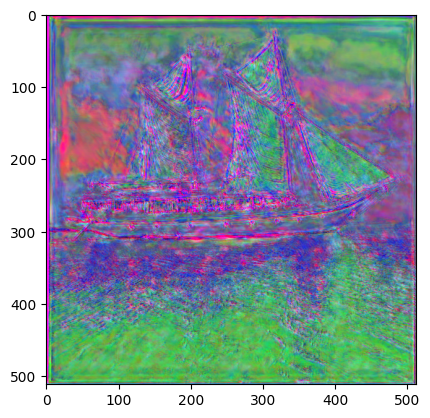

After 50 iters:
Total loss:  8032.44873046875
Content loss:  3.6797266006469727
patch loss:  0.79736328125
dir loss:  0.60791015625
TV loss:  0.4898545742034912


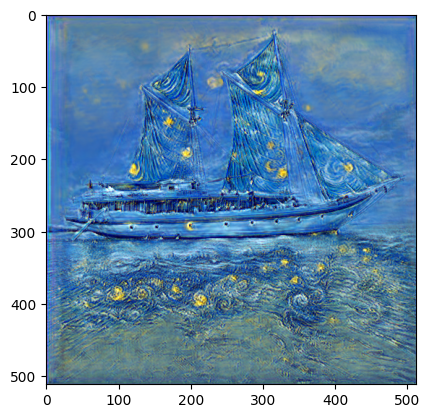

After 100 iters:
Total loss:  7590.9931640625
Content loss:  2.763685703277588
patch loss:  0.76904296875
dir loss:  0.51171875
TV loss:  0.5655661225318909


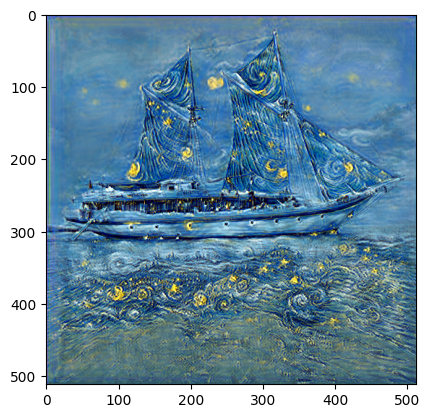

After 150 iters:
Total loss:  7394.00830078125
Content loss:  2.1943283081054688
patch loss:  0.76025390625
dir loss:  0.4404296875
TV loss:  0.6089823842048645


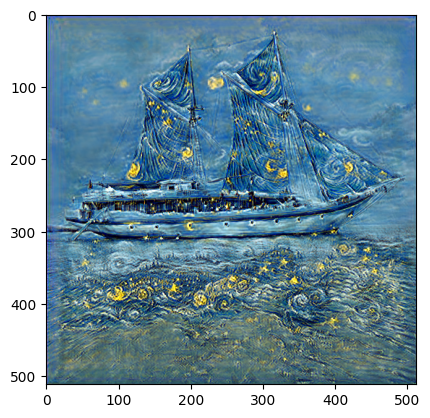

After 200 iters:
Total loss:  7287.99609375
Content loss:  2.015735149383545
patch loss:  0.7529296875
dir loss:  0.41796875
TV loss:  0.635879635810852


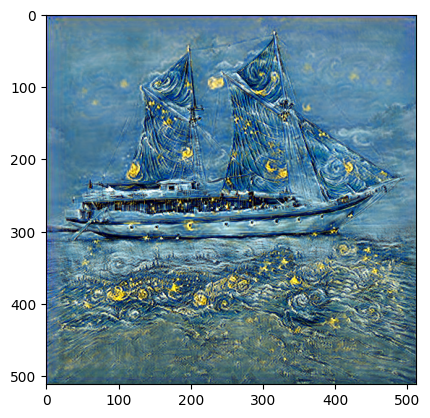

In [8]:
# original style transfer - CLIPStyler

from IPython.display import display
from argparse import Namespace

source = "a Photo"

# variables 
text = "Starry Night by Vincent Van Gogh"   # "Sketch with black pencil" 
crop_size = 128 
image_dir = f"../tcl/boat.jpeg" 
# save_path = f"../text-style-transfer/outputs/clipstyler_face1_wheatfield.png"
clip_model, preprocess = clip.load('ViT-B/32', device, jit=False)


training_iterations = 100  # default = 100

training_args = {
    "lambda_tv": 2e-3,
    "lambda_patch": 9000,
    "lambda_dir": 500,
    "lambda_c": 150,
    "crop_size": 128,
    "num_crops": 64,
    "img_height": 512,
    "img_width": 512,
    "max_step": training_iterations,
    "lr": 5e-4,
    "thresh": 0.7,
    "content_path": image_dir,
    "text": text
}

args = Namespace(**training_args)

def compose_text_with_templates(text: str, templates=imagenet_templates) -> list:
    return [template.format(text) for template in templates]

content_path = args.content_path
content_image = utils.load_image2(content_path, img_height=args.img_height, img_width =args.img_width)

content_image = content_image.to(device)

content_features = utils.get_features(img_normalize(content_image), VGG)

target = content_image.clone().requires_grad_(True).to(device)

style_net = StyleNet.UNet()
style_net.to(device)
style_net.load_state_dict(torch.load("./compositional.pth", map_location="cpu"))

style_weights = {'conv1_1': 0.1,
                 'conv2_1': 0.2,
                 'conv3_1': 0.4,
                 'conv4_1': 0.8,
                 'conv5_1': 1.6}

content_weight = args.lambda_c

show_every = 200
optimizer = optim.Adam(style_net.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
steps = args.max_step

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []

output_image = content_image

m_cont = torch.mean(content_image,dim=(2,3),keepdim=False).squeeze(0)
m_cont = [m_cont[0].item(),m_cont[1].item(),m_cont[2].item()]

cropper = transforms.Compose([
    transforms.RandomCrop(args.crop_size)
])
augment = transforms.Compose([
    transforms.RandomPerspective(fill=0, p=1,distortion_scale=0.5),
    transforms.Resize(224)
])

# clip_model, preprocess = clip.load('ViT-B/32', device, jit=False)

prompt = args.text

source = "a Photo"

with torch.no_grad():
    template_text = compose_text_with_templates(prompt, imagenet_templates)
    tokens = clip.tokenize(template_text).to(device)
    text_features = clip_model.encode_text(tokens).detach()
    text_features = text_features.mean(axis=0, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    template_source = compose_text_with_templates(source, imagenet_templates)
    tokens_source = clip.tokenize(template_source).to(device)
    text_source = clip_model.encode_text(tokens_source).detach()
    text_source = text_source.mean(axis=0, keepdim=True)
    text_source /= text_source.norm(dim=-1, keepdim=True)
    source_features = clip_model.encode_image(clip_normalize(content_image,device))
    source_features /= (source_features.clone().norm(dim=-1, keepdim=True))

    
num_crops = args.num_crops

import time
start = time.time()
steps = 200
for epoch in range(0, steps+1):
    
    scheduler.step()
    target = style_net(content_image,use_sigmoid=True).to(device)
    target.requires_grad_(True)
    
    target_features = utils.get_features(img_normalize(target), VGG)
    
    content_loss = 0

    content_loss += torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    content_loss += torch.mean((target_features['conv5_2'] - content_features['conv5_2']) ** 2)

    loss_patch=0 
    img_proc =[]
    for n in range(num_crops):
        target_crop = cropper(target)
#         print('target_crop size:', target_crop.size())
        target_crop = augment(target_crop)
#         print('target_crop size after augmentation:', target_crop.size())
        img_proc.append(target_crop)

    img_proc = torch.cat(img_proc,dim=0)
#     print('img_proc', img_proc.size())
    img_aug = img_proc

    image_features = clip_model.encode_image(clip_normalize(img_aug,device))
    image_features /= (image_features.clone().norm(dim=-1, keepdim=True))
    
    img_direction = (image_features-source_features)
    img_direction /= img_direction.clone().norm(dim=-1, keepdim=True)
    
    text_direction = (text_features-text_source).repeat(image_features.size(0),1)
    text_direction /= text_direction.norm(dim=-1, keepdim=True)
    loss_temp = (1- torch.cosine_similarity(img_direction, text_direction, dim=1))
    loss_temp[loss_temp<args.thresh] =0
    loss_patch+=loss_temp.mean()
    
    glob_features = clip_model.encode_image(clip_normalize(target,device))
    glob_features /= (glob_features.clone().norm(dim=-1, keepdim=True))
    
    glob_direction = (glob_features-source_features)
    glob_direction /= glob_direction.clone().norm(dim=-1, keepdim=True)
    
    loss_glob = (1- torch.cosine_similarity(glob_direction, text_direction, dim=1)).mean()
    
    reg_tv = args.lambda_tv*get_image_prior_losses(target)

    total_loss = args.lambda_patch*loss_patch + content_weight * content_loss+ reg_tv+ args.lambda_dir*loss_glob
    total_loss_epoch.append(total_loss)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print("After %d iters:" % epoch)
        print('Total loss: ', total_loss.item())
        print('Content loss: ', content_loss.item())
        print('patch loss: ', loss_patch.item())
        print('dir loss: ', loss_glob.item())
        print('TV loss: ', reg_tv.item())
    
    if epoch % 50 == 0:
        output_image = target.clone()
        output_image = torch.clamp(output_image,0,1)
        output_image = adjust_contrast(output_image,1.5)
        output_converted = utils.im_convert2(output_image)
        plt.imshow(output_converted)
        plt.show()
        
# print(type(output_converted), np.min(output_converted), np.max(output_converted))
# Image.fromarray((output_converted*255.).astype(np.uint8)).save(save_path)

# print(time.time() - start)

In [ ]:
!pip install python-papi

In [ ]:
from pypapi import events, papi_high as high

In [22]:
# Mask-CLIPstyler + Gatha(relational) loss 
from argparse import Namespace
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
import sys
import time

source = "a Photo"

text = f"colorful stained glass."   # "Sketch with black pencil" 
crop_size = 128
image_dir = f"../GroundingDINO/demo/assets/tcl/in45.png"  
save_path = f"../text-style-transfer/outputs/mclipstyler+gatha_church_cubism.png"
seg_path = f"../GroundingDINO/demo/outputs/in45_seg_teapot.png" # "../text-style-transfer/outputs/church_water_body_01.png"


training_iterations = 200 # @param {type: "integer"}

training_args = {
    "lambda_tv": 0,   # 2e-3, 0 
    "lambda_patch": 9000,  # 9000
    "lambda_dir": 500,  # 500
    "lambda_c": 100, # 150
    "lambda_identity": 0, # 7000
    "lambda_gatha": 0.00005,
    "crop_size": 128,
    "num_crops": 64,
    "img_height": 512,
    "img_width": 512,
    "max_step": training_iterations,
    "lr": 5e-4,
    "thresh": 0.7,
    "content_path": image_dir,
    "text": text
}


# training_args = {
#     "lambda_tv": 2e-3,  # 2e-3,0
#     "lambda_patch": 9000,
#     "lambda_dir": 500,
#     "lambda_c": 150,
#     "lambda_identity": 7000,
#     "lambda_gatha": 0.00005,
#     "crop_size": 128,
#     "num_crops":64,
#     "img_height":512,
#     "img_width":512,
#     "max_step":training_iterations,
#     "lr":5e-4,
#     "thresh":0.7,
#     "content_path":image_dir,
#     "text":text
# }

args = Namespace(**training_args)

def compose_text_with_templates(text: str, templates=imagenet_templates) -> list:
    return [template.format(text) for template in templates]

def get_bbox_from_seg(seg_mask):
    ones = torch.where(seg_mask == 1.)
    left, right, top, bottom = torch.min(ones[3]).item(), torch.max(ones[3]).item(), torch.min(ones[2]).item(), torch.max(ones[2]).item()
    return left, top, right, bottom

def get_crop_coordinates(pil_t, seg_mask, patch_size=args.crop_size):
    left, top, right, bottom = get_bbox_from_seg(seg_mask)
#     print(f'left: {left}, top: {top}, right: {right}, bottom: {bottom}')

    left_patch, top_patch = None, None
    right_limit = right-patch_size+1
    if right_limit < left:
        left_patch = np.random.randint(right_limit, left)

    bottom_limit = bottom-patch_size+1
    if bottom_limit < top:
        top_patch = np.random.randint(bottom_limit, top)

    if left_patch is None:
        left_patch = np.random.randint(left, right_limit)

    if top_patch is None:
        top_patch = np.random.randint(top, bottom_limit)
        
    return top_patch, left_patch, patch_size, patch_size

content_path = args.content_path
content_image = utils.load_image2(content_path, img_height=args.img_height,img_width =args.img_width)
content_image = content_image.to(device)

segmask_image = utils.load_seg_mask(seg_path, img_height=args.img_height, img_width=args.img_width)
segmask_image = segmask_image.to(device)

content_features = utils.get_features(img_normalize(content_image), VGG)

# '''
# to preserve the content of the image except the region being styled: content_image*(1.-segmask_image) 
# '''
masked_content_features = utils.get_features(img_normalize(content_image*(1.-segmask_image)), VGG)


target = content_image.clone().requires_grad_(True).to(device)


style_net = StyleNet.UNet(input_channel=4)  # input_channel=4
style_net.to(device)
style_net.load_state_dict(torch.load("./init_sty_channel4.pth", map_location='cpu'))  # nice trick to maintain consistency across experiments!

style_weights = {'conv1_1': 0.1,
                 'conv2_1': 0.2,
                 'conv3_1': 0.4,
                 'conv4_1': 0.8,
                 'conv5_1': 1.6}

content_weight = args.lambda_c

show_every = 100
optimizer = optim.Adam(style_net.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
steps = args.max_step

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []

output_image = content_image

m_cont = torch.mean(content_image,dim=(2,3),keepdim=False).squeeze(0)
m_cont = [m_cont[0].item(),m_cont[1].item(),m_cont[2].item()]

cropper = transforms.Compose([
    transforms.RandomCrop(args.crop_size)
])
augment = transforms.Compose([
    transforms.RandomPerspective(fill=0, p=1,distortion_scale=0.5),
    transforms.Resize(224)
])

# clip_model, preprocess = clip.load('ViT-B/32', device, jit=False)

prompt = args.text

source = "a Photo"

with torch.no_grad():
    template_text = compose_text_with_templates(prompt, imagenet_templates)
    tokens = clip.tokenize(template_text).to(device)
    text_features = clip_model.encode_text(tokens).detach()
    text_features = text_features.mean(axis=0, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    
    template_source = compose_text_with_templates(source, imagenet_templates)
    tokens_source = clip.tokenize(template_source).to(device)
    text_source = clip_model.encode_text(tokens_source).detach()
    text_source = text_source.mean(axis=0, keepdim=True)
    text_source /= text_source.norm(dim=-1, keepdim=True)
    source_features = clip_model.encode_image(clip_normalize(content_image,device))
    source_features /= (source_features.clone().norm(dim=-1, keepdim=True))
    style_embed = ( 1e3 * text_features.float() @ style_tensor.T.float()).detach().expand(64, len(styles))
    
    masked_source_features = clip_model.encode_image(clip_normalize(content_image*segmask_image,device))
    masked_source_features /= (masked_source_features.clone().norm(dim=-1, keepdim=True))


T = 1

criterion = nn.KLDivLoss()

num_crops = args.num_crops
bbox_left, bbox_top, bbox_right, bbox_bottom = get_bbox_from_seg(segmask_image)

# torch.save(style_net.state_dict(), './init_sty_channel4.pth')
# sys.exit("Model init saved.")
# start = 
import time
start = time.time()
# print(start)
n_itrs = 500
for epoch in range(n_itrs):
    scheduler.step()
    
    image_with_mask = torch.cat([content_image, segmask_image], dim=1)   # 1x4x512x512
    target = style_net(image_with_mask, use_sigmoid=True).to(device)
    target.requires_grad_(True)
    
    loss_identity = torch.nn.L1Loss()(target*(1.-segmask_image), content_image*(1.-segmask_image))
    
    target_features = utils.get_features(img_normalize(target), VGG)
    masked_target_features = utils.get_features(img_normalize(target*(1.-segmask_image)), VGG)
    
    content_loss = 0

    content_loss += torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    content_loss += torch.mean((target_features['conv5_2'] - content_features['conv5_2']) ** 2)

    loss_patch=0 
    img_proc =[]
    for n in range(num_crops):
        top, left, h, w = get_crop_coordinates(target, segmask_image)
        target_crop = transforms.functional.crop(target, top, left, h, w)
        seg_crop = transforms.functional.crop(segmask_image, top, left, h, w)
        target_crop = augment(target_crop*seg_crop)
        img_proc.append(target_crop)

    img_proc = torch.cat(img_proc,dim=0)
    img_aug = img_proc

    image_features = clip_model.encode_image(clip_normalize(img_aug,device))
    image_features /= (image_features.clone().norm(dim=-1, keepdim=True))
    
    img_direction = (image_features-source_features)
    img_direction /= img_direction.clone().norm(dim=-1, keepdim=True)
    
    text_direction = (text_features-text_source).repeat(image_features.size(0),1)
    text_direction /= text_direction.norm(dim=-1, keepdim=True)
    loss_temp = (1. - torch.cosine_similarity(img_direction, text_direction, dim=1))
    loss_temp[loss_temp<args.thresh] =0
    loss_patch+=loss_temp.mean()
    
#     glob_features = clip_model.encode_image(clip_normalize(target,device))
#     glob_features /= (glob_features.clone().norm(dim=-1, keepdim=True))
    
#     glob_direction = (glob_features-source_features)
#     glob_direction /= glob_direction.clone().norm(dim=-1, keepdim=True)
    
    masked_glob_features = clip_model.encode_image(clip_normalize(target*segmask_image, device))
    masked_glob_features /= (masked_glob_features.clone().norm(dim=-1, keepdim=True))
    
    glob_direction = (masked_glob_features - masked_source_features)
    glob_direction /= glob_direction.clone().norm(dim=-1, keepdim=True)
    
    loss_glob = (1- torch.cosine_similarity(glob_direction, text_direction, dim=1)).mean()
    
    reg_tv = args.lambda_tv*get_image_prior_losses(target)  # (target*segmask_image)

    
#     sty_lab = (sty_lab - sty_lab.min())/(sty_lab.max() - sty_lab.min())
#     sty_lab2 = (1e3 * glob_features.float() @ style_tensor.T)
#     style_embed = (style_embed - style_embed.min()) / (style_embed.max() - style_embed.min())


    sty_lab = (1e3 * image_features.float() @ style_tensor.T.float())
 

    kl = args.lambda_gatha * F.mse_loss(sty_lab, style_embed) 

#     + 0.0001 * F.mse_loss(sty_lab2, style_embed[0].unsqueeze(0))
    total_loss = args.lambda_patch*loss_patch + content_weight * content_loss+ reg_tv+ args.lambda_dir*loss_glob +\
                    args.lambda_identity*loss_identity 

    total_loss += kl

    total_loss_epoch.append(total_loss)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

end = time.time()
# 40.12788772583008
# 40.32555675506592

# 60.38
# 60.02709889411926
# 100.91146492958069
#100.38118934631348
print(end-start)

100.38118934631348
